In [50]:
X_DIM = 256
Y_DIM = 256
UNPROCESSED_DIRECTORY = "CNN_synth_testset"
PROCESSED_DIRECTORY = "processed_images"
CROP = False
import os
import numpy as np
from PIL import Image as im_lib
from PIL import ImageFilter
from keras.layers import Layer, Input, concatenate, MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from keras import models, Model
from keras import layers
from keras.utils import Sequence
from keras.utils import plot_model
from keras.metrics import Metric
import keras.backend as backend
import tensorflow as tf
from math import ceil
from sklearn.model_selection import train_test_split
import time

In [51]:
def obtain_image_paths(unprocessed_directory = UNPROCESSED_DIRECTORY):
    data_directory = os.listdir("./"+unprocessed_directory)
    list_of_image_paths = []
    for dirpath, dirname, filename in os.walk("./"+unprocessed_directory):
        if not dirname:
            for dirpath2, dirname2, filename2 in os.walk(dirpath):
                for filedir in filename2:
                    list_of_image_paths.append(dirpath+"/"+filedir)
    return list_of_image_paths

In [52]:
#Create constants and import libraries
def categorical_output(image_path):
    keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2", "stylegan",
           "whichfaceisreal"]
    category = [0] * (len(keywords) + 1)
    for kwd_index in range(len(keywords)):
        kwd = keywords[kwd_index]
        if kwd in image_path:
            category[kwd_index] = 1
            return category
    category[-1] = 1
    return category
class ImageBatchSequence(Sequence):
    def __init__(self, x_set, batch_size, x_dim = X_DIM, y_dim = Y_DIM, filter_function_1 = None, filter_function_2 = None, 
                 output_function = None, normalizing_factor = 255):
        self.x = x_set
        if output_function is None:
            y_set = [(1 if "fake" in image_path else 0) for image_path in x_set] #This makes the output to be 1 (AI-generated) if FAKE is in pathname.
            #                                                  # Otherwise, it makes the output 0 (not AI-generated)
        else:
            y_set = [output_function(image_path) for image_path in x_set]
        self.y = y_set
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.filter_function_1 = filter_function_1
        self.filter_function_2 = filter_function_2 #might want to rewrite for a list of filter functions
        self.normalizing_factor = normalizing_factor
    def __len__(self):
        return ceil(len(self.x)/self.batch_size)
    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low+self.batch_size, len(self.x))
        batch_x = self.x[low : high]
        batch_y = self.y[low : high]
        image_x_batch_1 = []
        image_x_batch_2 = []
        for image_path in batch_x:
            image = im_lib.open(image_path)
            if self.filter_function_1 is not None:
                image_1 = self.filter_function_1(image)
            image_array_1 = np.asarray(image_1).reshape(self.x_dim,self.y_dim,3)/self.normalizing_factor
            image_x_batch_1.append(image_array_1)
            if self.filter_function_2 is not None:
                image_2 = self.filter_function_2(image)
            image_array_2 = np.asarray(image).reshape(self.x_dim,self.y_dim,3)/self.normalizing_factor
            image_x_batch_2.append(image_array_2)
        return [np.array(image_x_batch_1),np.array(image_x_batch_2)], np.array(batch_y)

In [53]:
X = obtain_image_paths("Test1_modular")
y = [categorical_output(x) for x in X]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2, stratify = y)

In [55]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan", "stylegan",
           "stylegan2","whichfaceisreal"]
for kwd in keywords:
    print(kwd+":"+str(y_train.count(categorical_output(kwd))))
print("real : "+str(y_train.count(categorical_output("fuck"))))
print(";;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;")
for kwd in keywords:
    print(kwd+":"+str(y_test.count(categorical_output(kwd))))
print("real : "+str(y_test.count(categorical_output("fuck"))))

biggan:1600
crn:5105
cyclegan:1056
deepfake:2158
gaugan:4000
imle:8306
progan:0
san:173
seeingdark:143
stargan:1599
stylegan:11182
stylegan2:0
whichfaceisreal:0
real : 36930
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
biggan:400
crn:1276
cyclegan:264
deepfake:540
gaugan:1000
imle:2076
progan:0
san:43
seeingdark:36
stargan:400
stylegan:2796
stylegan2:0
whichfaceisreal:0
real : 9232


In [56]:
X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 254, 254, 32)         896       ['input_9[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 254, 254, 32)         896       ['input_10[0][0]']            
                                                                                            

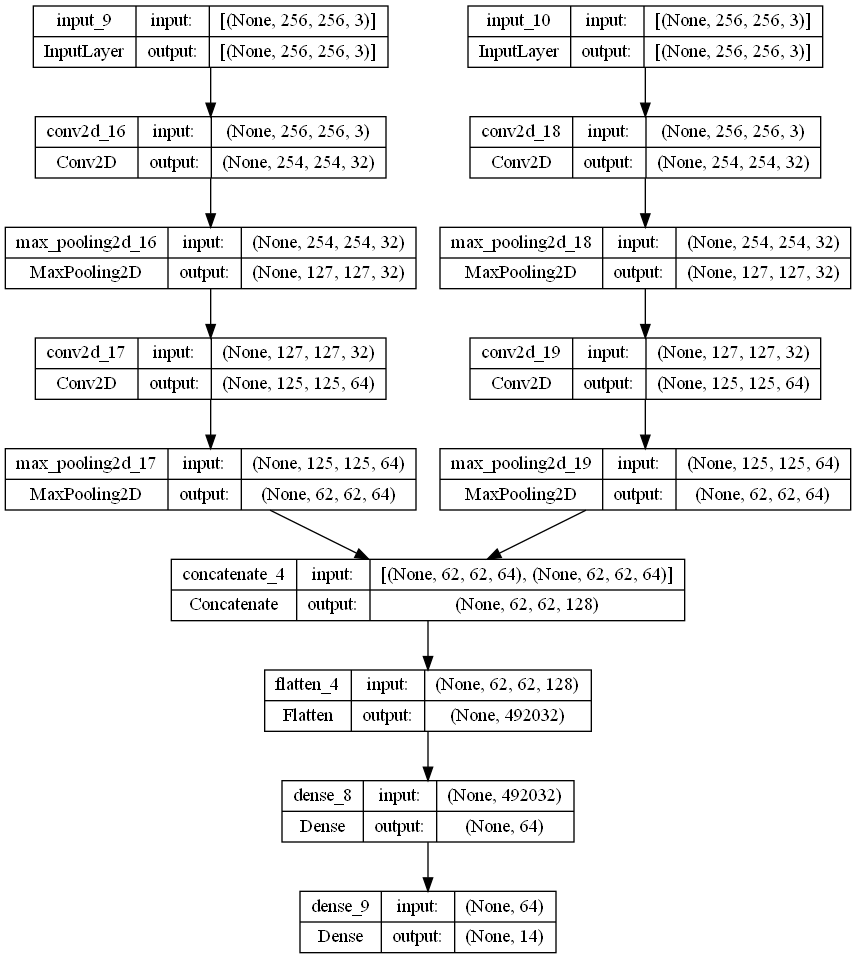

In [57]:
#HPF Filter
hpf_input = Input(shape=(256,256,3))
hpf_1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(hpf_input)
hpf_2 = MaxPooling2D(pool_size=(2,2),strides=2)(hpf_1)
hpf_3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(hpf_2)
hpf_4 = MaxPooling2D(pool_size=(2,2),strides=2)(hpf_3)

#highpass filter
highpass_input = Input(shape=(256,256,3))
highpass_1 = Conv2D(filters=32,kernel_size=(3,3),activation='relu')(highpass_input)
highpass_2 = MaxPooling2D(pool_size=(2,2),strides=2)(highpass_1)
highpass_3 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(highpass_2)
highpass_4 = MaxPooling2D(pool_size=(2,2),strides=2)(highpass_3)


merged_1 = concatenate([hpf_4, highpass_4])
merged_2 = Flatten()(merged_1)
merged_3 = Dense(units=64, activation='relu')(merged_2)
multiclass= Dense(units=14, activation = 'softmax')(merged_3)
#binary = Dense(units=1,activation='softmax')(merged_3)

model = Model(inputs = [hpf_input,highpass_input], outputs = multiclass)


model.summary()
plot_model(model, show_shapes=True)

In [58]:
class MulticlassPrecisionMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassPrecisionMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_tf_positives = self.add_weight(name = 'tfp' + str(self.category_tested), initializer = 'zeros')
        self.mp = self.add_weight(name = 'mp' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred, sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_tf_positives.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_pred,self.category_tested),tf.float32)))
        self.mp.assign(self.multi_true_positives/(self.multi_tf_positives+backend.epsilon()))
    def result(self):
        return self.mp

In [59]:
class MulticlassRecallMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassRecallMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_predic = self.add_weight(name = 'tpr' + str(self.category_tested), initializer = 'zeros')
        self.mr = self.add_weight(name = 'mr' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred,sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_predic.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_true,self.category_tested),tf.float32)))
        self.mr.assign(self.multi_true_positives/(self.multi_predic+backend.epsilon()))
    def result(self):
        return self.mr

In [60]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2",
            "stylegan", "whichfaceisreal"]
METRICS = []
for kwd_index in range(len(keywords)):
    precision_metric = MulticlassPrecisionMetric(name = "precision_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    recall_metric = MulticlassRecallMetric(name = "recall_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    METRICS.append(precision_metric)
    METRICS.append(recall_metric)
precision_metric = MulticlassPrecisionMetric(name = "precision_real", category_tested = len(keywords))
recall_metric = MulticlassRecallMetric(name = "recall_real", category_tested = len(keywords))
METRICS.append(precision_metric)
METRICS.append(recall_metric)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = [METRICS])

In [61]:
def HPF_filter(image):
    return im_lib.fromarray(np.asarray(image)-np.asarray(image.filter(ImageFilter.GaussianBlur)))

In [62]:
#combines the filters for each color channel as one image
def highpassrgb(image):
    red, green, blue = image.split()
    return im_lib.merge(mode='RGB',bands=(red.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), green.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), blue.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0))))

#each as a separate image
def highpassrgb2(image):
    red, green, blue = image.split()
    return red.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), green.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0)), blue.filter(ImageFilter.Kernel((3,3),(0,-1,0,-1,4,-1,0,-1,0),1,0))


In [63]:
train_sequence = ImageBatchSequence(X_train_train, batch_size = 32, filter_function_1 = HPF_filter, filter_function_2 = highpassrgb, 
                                    output_function = categorical_output)
validation_sequence = ImageBatchSequence(X_val, batch_size = 32, filter_function_1 = HPF_filter, filter_function_2 = highpassrgb,
                                    output_function = categorical_output)

In [64]:
model.fit(train_sequence, epochs = 2, validation_data = validation_sequence)

Epoch 1/2
   8/1807 [..............................] - ETA: 36:34 - loss: 13.2084 - precision_biggan: 0.0000e+00 - recall_biggan: 0.0000e+00 - precision_crn: 0.0769 - recall_crn: 0.0455 - precision_cyclegan: 0.0000e+00 - recall_cyclegan: 0.0000e+00 - precision_deepfake: 0.0000e+00 - recall_deepfake: 0.0000e+00 - precision_gaugan: 0.0000e+00 - recall_gaugan: 0.0000e+00 - precision_imle: 0.1739 - recall_imle: 0.2500 - precision_progan: 0.0000e+00 - recall_progan: 0.0000e+00 - precision_san: 0.0000e+00 - recall_san: 0.0000e+00 - precision_seeingdark: 0.0000e+00 - recall_seeingdark: 0.0000e+00 - precision_stargan: 0.0000e+00 - recall_stargan: 0.0000e+00 - precision_stylegan2: 0.0000e+00 - recall_stylegan2: 0.0000e+00 - precision_stylegan: 0.2188 - recall_stylegan: 0.2258 - precision_whichfaceisreal: 0.0000e+00 - recall_whichfaceisreal: 0.0000e+00 - precision_real: 0.5306 - recall_real: 0.5909                   

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
ValueError: cannot reshape array of size 65536 into shape (256,256,3)
Traceback (most recent call last):

  File "C:\Users\19166\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\19166\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\19166\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\19166\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\19166\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\data_adapter.py", line 1064, in generator_fn
    yield x[i]
          ~^^^

  File "C:\Users\19166\AppData\Local\Temp\ipykernel_11416\3174533345.py", line 42, in __getitem__
    image_array_1 = np.asarray(image_1).reshape(self.x_dim,self.y_dim,3)/self.normalizing_factor
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: cannot reshape array of size 65536 into shape (256,256,3)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_5838]